In [166]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator, Sampler
from qiskit_aer.noise import NoiseModel

from squlearn import Executor
from squlearn.encoding_circuit import QiskitEncodingCircuit
from squlearn.observables import SinglePauli
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam, SLSQP, SGLBO
from squlearn.encoding_circuit import *

import matplotlib.pyplot as plt
import matplotlib as mpl

In [167]:
nqubits = 4

qc = QuantumCircuit(4)
p = ParameterVector('p', 8)
x = ParameterVector('x', 1)

p2 = np.array([-0.13005136, -1.34331017,  2.44392299, 1.64405423, -0.36315523, 0.45344925,
  0.18577077, -0.13904446])

qc.h(range(nqubits))
qc.rz(p[0], 0)
qc.rz(p[1], 1)
qc.rz(p[2], 2)
qc.rz(p[3], 3)

qc.rx(1*np.arccos(x[0]), 0)
qc.rx(2*np.arccos(x[0]), 1)
qc.rx(3*np.arccos(x[0]), 2)
qc.rx(4*np.arccos(x[0]), 3)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 0)

qc.ry(1*np.arccos(p[4]), 0)
qc.ry(2*np.arccos(p[5]), 1)
qc.ry(3*np.arccos(p[6]), 2)
qc.ry(4*np.arccos(p[7]), 3)

qc.cx(0, 1)
qc.cx(2, 3)
qc.cx(1, 2)
qc.cx(3, 0)

pqc = QiskitEncodingCircuit(qc)

pqc.draw()

┌───┐  ┌──────────┐  ┌────────────────┐           ┌───┐┌────────────┐     »
q_0: ┤ H ├──┤ Rz(p[0]) ├──┤ Rx(acos(x[0])) ├───■───────┤ X ├┤ Ry(1.9424) ├──■──»
     ├───┤┌─┴──────────┴┐┌┴────────────────┴┐┌─┴─┐     └─┬─┘├────────────┤┌─┴─┐»
q_1: ┤ H ├┤ Rz(-1.3433) ├┤ Rx(2*acos(x[0])) ├┤ X ├──■────┼──┤ Ry(2.2003) ├┤ X ├»
     ├───┤└┬────────────┤├──────────────────┤└───┘┌─┴─┐  │  ├────────────┤└───┘»
q_2: ┤ H ├─┤ Rz(2.4439) ├┤ Rx(3*acos(x[0])) ├──■──┤ X ├──┼──┤ Ry(4.1518) ├──■──»
     ├───┤ ├────────────┤├──────────────────┤┌─┴─┐└───┘  │  ├────────────┤┌─┴─┐»
q_3: ┤ H ├─┤ Rz(1.6441) ├┤ Rx(4*acos(x[0])) ├┤ X ├───────■──┤ Ry(6.8412) ├┤ X ├»
     └───┘ └────────────┘└──────────────────┘└───┘          └────────────┘└───┘»
«          ┌───┐
«q_0: ─────┤ X ├
«          └─┬─┘
«q_1: ──■────┼──
«     ┌─┴─┐  │  
«q_2: ┤ X ├──┼──
«     └───┘  │  
«q_3: ───────■──
«

In [168]:
op = SinglePauli(nqubits,qubit=0,parameterized=True)
print(op)

SparsePauliOp(['IIIZ'],
              coeffs=[ParameterExpression(1.0*p[0])])


In [169]:
op.num_parameters

1

In [170]:
# Randomly initialize parameters of the encoding circuit
np.random.seed(13) #13
param_ini =  np.random.rand(pqc.num_parameters)
#param_ini = np.array([-0.142])
# Initialize parameters of the observable as ones
param_op_ini = np.ones(op.num_parameters)
#param_op_ini = np.array([6.135])
x0 = [[i * 0.02] for i in range(15)]
optimizer_options = {"bo_aqc_func": "EI", "bo_aqc_optimizer": "lbfgs", "bo_bounds": [(0.0, 0.3)], "log_file": "sglbo_noiseless.log",
                     "bo_n_calls": 30, "bo_x0_points": x0, "maxiter": 100, "bo_bounds_fac": 0.1}

qnn_simulator = QNNRegressor(
    pqc,
    op,
    Executor("statevector_simulator"),
    SquaredLoss(),
    SGLBO(optimizer_options),
    #SLSQP(),
    #Adam({"lr": 0.2,"log_file": "adam_noiseless.log"}),
    param_ini,
    param_op_ini=param_op_ini,
    opt_param_op=True, # Keine Observablen optimierung
    parameter_seed=124
)

In [171]:
print(param_ini)
print(param_op_ini)

[0.77770241]
[1.]


In [172]:
# Data that is inputted to the QNN
x_train = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y_train = np.sin(6.0*x_train)

In [173]:
def evaluate_loss(theta, qnn_regressor: QNNRegressor, X, y):
    param = theta[: qnn_regressor._qnn.num_parameters]
    param_op = theta[qnn_regressor._qnn.num_parameters :]

    loss_values = qnn_regressor._qnn.evaluate(qnn_regressor.loss.loss_args_tuple, X, param, param_op)

    loss_value = qnn_regressor.loss.value(
        loss_values,
        ground_truth=y,
        weights=np.ones(len(y)),
        iteration=0,
    )

    return loss_value




In [174]:
qnn_simulator.fit(x_train, y_train)

fit:   0%|          | 0/100 [00:00<?, ?it/s]BOP  fval:  5.780929008859998  x:  [0.0]
BOP  fval:  5.732278294379681  x:  [0.028767515247672373]
BOP  fval:  5.685831224214622  x:  [0.057535030495344745]
BOP  fval:  5.641580255234399  x:  [0.08630254574301713]
BOP  fval:  5.599518190537202  x:  [0.11507006099068949]
BOP  fval:  5.559638180358053  x:  [0.14383757623836185]
BOP  fval:  5.521933722936001  x:  [0.17260509148603426]
BOP  fval:  5.486398665340215  x:  [0.20137260673370663]
BOP  fval:  5.4530272042549095  x:  [0.23014012198137898]
BOP  fval:  5.421813886723002  x:  [0.25890763722905136]
BOP  fval:  5.392753610848457  x:  [0.2876751524767237]
BOP  fval:  5.365841626457218  x:  [0.3164426677243961]
BOP  fval:  5.341073535716696  x:  [0.3452101829720685]
BOP  fval:  5.3184452937137  x:  [0.37397769821974086]
BOP  fval:  5.297953208990824  x:  [0.40274521346741327]
BOP  fval:  5.4250608051341445  x:  [0.2558199989143309]
BOP  fval:  5.325810221126592  x:  [0.3643114169308793]
BOP  f

In [175]:
qnn_simulator.param

array([2.62679027])

In [176]:
qnn_simulator.param_op

array([0.24009728])

In [177]:
evaluate_loss([qnn_simulator.param,qnn_simulator.param_op], qnn_simulator, x_train, y_train)

5.153200970295608

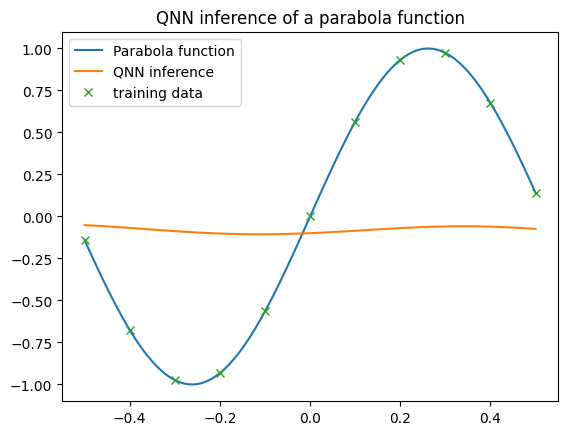

In [178]:
x = np.arange(np.min(x_train), np.max(x_train) + 0.01, 0.01)
y = qnn_simulator.predict(x)  # function for evaluating the prediction of the QNN
plt.plot(x, np.sin(6.0*x), label="Parabola function")
plt.plot(x, y, label="QNN inference")
plt.plot(x_train, y_train, "x", label="training data")
plt.legend()
plt.title("QNN inference of a parabola function")
plt.show()

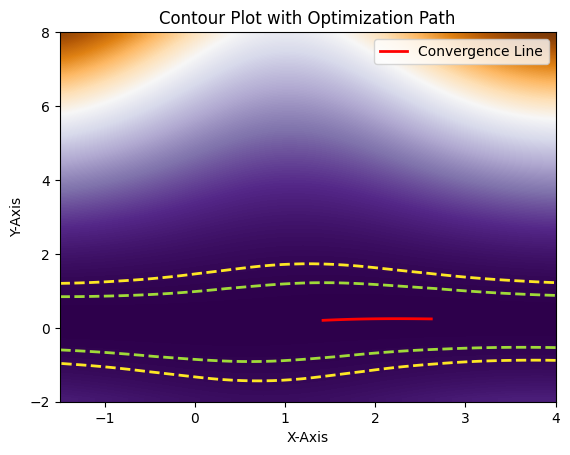

In [179]:
# Lese die Optimierungskoordinaten aus der Datei "params.log"
optimization_data = np.loadtxt("sglbo_noiseless_params2.log")
optimization_x = optimization_data[:, 0]
optimization_y = optimization_data[:, 1]

# plot the decision function for each datapoint on the grid
xx, yy = np.meshgrid(np.linspace(-1.5, 4, 50), np.linspace(-2, 8, 50))
Z = []
for i in range(len(xx)):
    for j in range(len(xx[i])):
        param = np.array([xx[i][j], yy[i][j]])
        Z.append(evaluate_loss(param, qnn_simulator, x_train, y_train))

Z = np.array(Z)
Z = Z.reshape(xx.shape)
#norm = mpl.colors.Normalize(vmin=-max(abs(np.min(Z)),abs(np.max(Z))), vmax=max(abs(np.min(Z)),abs(np.max(Z))))
im = plt.imshow(
    Z,
    interpolation="bilinear",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    aspect="auto",
    origin="lower",
    cmap=plt.cm.PuOr_r,
    #norm=norm
)

# Verbinde die Punkte im Scatter Plot mit einer Linie
plt.plot(optimization_x, optimization_y, c='red', linestyle='-', linewidth=2, label='Convergence Line')

# Plot backtransformed hyperplane
contours = plt.contour(xx, yy, Z, levels=[0,0.5,1,2,3,4,5,6,7], linewidths=2, linestyles="dashed")

# Plot training data
plt.axis([-1.5, 4, -2, 8])
plt.xlabel('X-Axis')
plt.ylabel('Y-Axis')
plt.title('Contour Plot with Optimization Path')
plt.legend()
plt.show()